In [1]:
%pwd

u'/home/shared/srp'

In [2]:
%pylab inline

/home/femianjc/anaconda2/envs/srp/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib



# Setup

On Ubuntu, I set up my environment like this:

```#!bash

    conda config --add channels conda-forge
    conda create -n srp python=2
    
    source activate srp
    conda install -y anaconda
    conda install -y laspy
    conda install -y fiona
    conda install -y shapely
    conda install -y rasterio
    pip install tqdm
    pip install pyproj
```


In [28]:
import os
import laspy
import fiona
import shapely
import shapely.geometry
import rasterio
from pprint import pprint
from tqdm import tnrange

In [4]:
import rasterio.crs

In [5]:
from tqdm import tnrange, tqdm
from glob import glob
from time import sleep
import gc

In [6]:
import traceback

In [7]:
from tqdm import tqdm_notebook
from multiprocessing import Pool, cpu_count

print cpu_count(), "cpu cores on this machine"

40 cpu cores on this machine


In [8]:
VECTOR_DATA_FN = r'/home/liux13/Desktop/tmp/boxes_section11.shp'
assert os.path.isfile(VECTOR_DATA_FN)

In [9]:
GROUND_FN = r'/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/merged_ground.asc'
assert os.path.isfile(GROUND_FN)

In [10]:
OUTPUT_METERS_PER_PIXEL = .05 # five centimeters, about 2 inches
OUTPUT_PADDING = 5 # expand output region 5  meters (to fit a local neighborhood into the image at the edges)

In [11]:
SLICE_THICKNESS = 0.313

In [12]:
OUTPUT_FN = './stack.vrt'

# Open the vector Data
The vector data is used to determine the region of inters

In [13]:
vector_file = fiona.open(VECTOR_DATA_FN)

In [14]:
minx, miny, maxx, maxy = vector_file.bounds

# Expand the region so that a local windo centered at points on the edges
# does not goi outside the grid
minx -= OUTPUT_PADDING
miny -= OUTPUT_PADDING
maxx += OUTPUT_PADDING
maxy += OUTPUT_PADDING

print "Region of interest (based on vector data)"
print minx, miny, "--", maxx, maxy 

Region of interest (based on vector data)
231638.410976 251008.999357 -- 233216.25982 252568.834735


In [15]:
width_in_meters = maxx-minx
height_in_meters = maxy-miny
print 'width (m):', width_in_meters
print 'height (m):', height_in_meters

width (m): 1577.84884394
height (m): 1559.83537839


In [16]:
grid_width = int(round(width_in_meters/OUTPUT_METERS_PER_PIXEL))
grid_height = int(round(height_in_meters/OUTPUT_METERS_PER_PIXEL))
print 'grid width (cols):', grid_width
print 'grid height (rows):', grid_height

grid width (cols): 31557
grid height (rows): 31197


In [17]:
pattern = os.path.join(r'/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/*.laz')
las_files = glob(pattern)
print len(las_files)

1680


In [18]:
def save_stack(stack, las_fn, min_point, max_point, las_width, las_height):
    output_transform = rasterio.transform.from_bounds(min_point[0], min_point[1],
                                                      max_point[0], max_point[1], 
                                                      las_width, las_height)
    output_crs = rasterio.crs.from_epsg(26949)

    output_fn = os.path.split(las_fn)[1][:-3] + 'tif'
    if os.path.isfile(output_fn):
        os.remove(output_fn)
        
    output_file = rasterio.open(output_fn, 'w', 
                            driver=u'GTiff', 
                            crs = output_crs,
                            transform=output_transform,
                            dtype=rasterio.uint16, 
                            count=3, 
                            width=las_width, 
                            height=las_height)
    
    output_file.write(indexes=(1,2,3), src=stack.astype(np.uint16))
    
    output_file.close()
    return output_fn

In [19]:
def process_las_file(las_fn):
    """Processes a single LAS/LAZ file
    This function either returns the name of a file, or an exception object. 
    It is intended to be used in multiprocwesing.Pool.imap
    """
    output_fn = ''
    gc.collect()
    try:
        las_file = laspy.file.File(las_fn)
        X = las_file.x
        Y = las_file.y
        Z = las_file.z
        min_point = las_file.header.min
        max_point = las_file.header.max
        las_file.close()

        las_min_x = int(floor((min_point[0]-minx) / OUTPUT_METERS_PER_PIXEL))
        las_min_y = int(floor((min_point[1]-miny) / OUTPUT_METERS_PER_PIXEL))
        las_max_x = int(floor((max_point[0]-minx) / OUTPUT_METERS_PER_PIXEL))
        las_max_y = int(floor((max_point[1]-miny) / OUTPUT_METERS_PER_PIXEL))
        las_width = las_max_x - las_min_x+1
        las_height = las_max_y - las_min_y+1

        if max_point[0] < minx or min_point[0] > maxx or max_point[1] < miny or min_point[1] > maxy:
            return "Skipping {}, out-of-bounds file".format(os.path.split(las_fn)[1])

        ground_file = rasterio.open(GROUND_FN)
        ground_min_x, ground_min_y = ~(ground_file.affine)*(min_point[0], min_point[1])
        ground_max_x, ground_max_y = ~(ground_file.affine)*(max_point[0], max_point[1])
        ground_min_x = int(round(ground_min_x))
        ground_min_y = int(round(ground_min_y))
        ground_max_x = int(round(ground_max_x))
        ground_max_y = int(round(ground_max_y))

        flipped = False
        if ground_max_y <  ground_min_y:
            ground_min_y, ground_max_y = ground_max_y, ground_min_y
            flipped = True

        ground_width = ground_max_x-ground_min_x + 1
        ground_height = ground_max_y - ground_min_y + 1

        ground = ground_file.read(1, window=((ground_min_y, ground_max_y+1), (ground_min_x, ground_max_x+1)), 
                                  boundless=True)
        if flipped:
            ground = ground[::-1,:] 
        ground_file.close()

        C = np.floor(((X - minx)/OUTPUT_METERS_PER_PIXEL)).astype(int) - las_min_x
        R = np.floor(((Y - miny)/OUTPUT_METERS_PER_PIXEL)).astype(int) - las_min_y

        height_above_ground = Z - ground[(R*ground_height)/las_height, (C*ground_width)/las_width]      

        level = np.floor((height_above_ground)/SLICE_THICKNESS).astype(int)
        
        def _generate_level(lvl):
            bc = np.bincount(R[level==lvl]*las_width + C[level==lvl], minlength=las_width*las_height)
            output = bc.reshape((las_height, las_width)).astype(float)
            return output

        stack = np.stack([_generate_level(lvl) for lvl in 1,2,3])

        # I seem to be working upside-down...
        output_fn = save_stack(stack[:,::-1,:], las_fn,  min_point, max_point, las_width, las_height)
    except e:
        return (e, traceback.format_exc())
    
    return output_fn 

In [20]:
print process_las_file(las_files[41])
print process_las_file(las_files[-1])

Skipping tile_231350_251400.laz, out-of-bounds file
Skipping tile_233600_252200.laz, out-of-bounds file


In [21]:
jobs = las_files #[:10]

for i in 0, 1, 2:
    print '{:04}'.format(i), jobs[i]
print "..."    
for i in len(jobs)-3, len(jobs)-2, len(jobs)-1:
    print '{:04}'.format(i), jobs[i]

0000 /mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231200_252550.laz
0001 /mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231250_251350.laz
0002 /mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231250_251400.laz
...
1677 /mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_233450_252250.laz
1678 /mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_233500_252100.laz
1679 /mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_233600_252200.laz


In [22]:
import gc
gc.collect()

136

In [23]:
if not os.path.isfile('./try2/stack.vrt'):
    workers = Pool(processes=20)
    try:
        pbar = tqdm_notebook(total=len(jobs))
        completed = []
        for output_fn in workers.imap(process_las_file, jobs):
            print output_fn
            completed.append(output_fn)
            pbar.update(1)
    finally:
        workers.terminate()
        workers.close()
        pbar.close()

In [66]:
!gdalbuildvrt stack.vrt tile_*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


# Chek the result

In [25]:
output_ds = rasterio.open('try2/stack.vrt')

:NOTE:  Somehow fiona was unable to open the shapefil, so I converted it to a GeoJSON file with
```
    ogr2ogr boxe_section11.json boxes_section11.shp -f GeoJSON 
```

In [26]:
vector_file = fiona.open('./boxes11/boxes_section11.json')
print vector_file.meta

{'crs': {'init': u'epsg:4326'}, 'driver': u'GeoJSON', 'schema': {'geometry': 'LineString', 'properties': OrderedDict([(u'id', 'str')])}}


In [29]:
hotspots = [shapely.geometry.shape(f['geometry']).centroid for f in vector_file if f['geometry'] is not None]

In [388]:
hs = hotspots[randint(len(hotspots))]
ctr = np.concatenate(hs.xy)

[ 232798.81601378  252381.06256688]
[24001  4379]


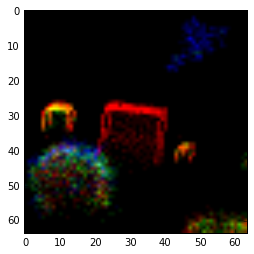

In [389]:
print ctr
cr = np.asarray(~output_ds.affine * ctr).astype(int)
c, r = cr
print cr

data = output_ds.read(window=((r-32, r+32), (c-32, c+32)), boundless=True)

imshow((data.transpose(1,2,0)/20.).clip(0, 1))

In [61]:
rgb = rasterio.open('./rgb/rgb.vrt')

In [66]:
import pyproj

In [82]:
EPSG2223 = pyproj.Proj(init="epsg:2223", preserve_units=True)
EPSG26949 = pyproj.Proj(init="epsg:26949", preserve_units=True)
print EPSG2223.srs
print EPSG26949.srs

+init=epsg:2223 
+init=epsg:26949 


In [84]:
rgb_ctr = pyproj.transform(EPSG26949, EPSG2223, ctr[0], ctr[1])
print ctr, rgb_ctr

[ 232881.14047861  251166.1091706 ] (764045.7364783867, 824035.7912421289)


[ 8182 10580]


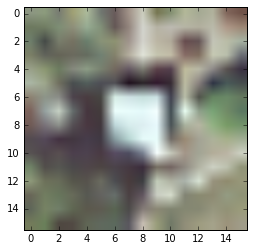

In [91]:
rgb_cr = np.asarray(~rgb.affine * rgb_ctr).astype(int)
print rgb_cr
rgb_data = rgb.read(window=((rgb_cr[1]-8, rgb_cr[1]+8), (rgb_cr[0]-8, rgb_cr[0]+8)), boundless=True)
imshow(rgb_data.transpose(1,2,0))

In [473]:
%%file data_provider.py

import pyproj
import rasterio
import numpy as np
import scipy.ndimage
from scipy.ndimage import zoom
from math import cos, sin, radians

EPSG2223 = pyproj.Proj(init="epsg:2223", preserve_units=True)
EPSG26949 = pyproj.Proj(init="epsg:26949", preserve_units=True)
        
class DataProvider(object):
    def __init__(self):        
        self.densities_path = '/home/shared/srp/try2/stack.vrt'
        self.colors_path = '/home/shared/srp/rgb/rgb.vrt'
        self._open_datasets()
      
    def _open_datasets(self):
        self.densities = rasterio.open(self.densities_path)
        self.colors = rasterio.open(self.colors_path)
    
    def get_patch_xyr(self, x, y, angle, radius_in_pixels=32):
        source_patch = self.get_patch_xy(x, y, radius_in_pixels*2)
        width = height = 2*radius_in_pixels
                
        radians = np.radians(angle)
        c, s = cos(radians), sin(radians)
        R = np.matrix([[c, -s], 
                       [s, c]])
        X = np.asarray([width, height])
        X = np.asarray(X-R.dot(X)).flatten()
        
        rotated_patch = np.empty_like(source_patch)
        for i in range(len(rotated_patch)):
            scipy.ndimage.affine_transform(source_patch[i],
                                           matrix=R, offset=X, 
                                           output_shape = rotated_patch[i].shape,
                                           output=rotated_patch[i])
        
        x, y = int((source_patch.shape[2]-width)/2), int( (source_patch.shape[1]-height)/2)
        cropped_patch = rotated_patch[:, y:y+height, x:x+width].copy()
        return cropped_patch    
        
    
    def get_patch_xy(self, x, y, radius_in_pixels=32):
        R = radius_in_pixels
        x_2223, y_2223 = pyproj.transform(EPSG26949, EPSG2223, x, y)
        c_2223, r_2223 = np.asarray(~self.colors.affine * (x_2223, y_2223)).astype(int)
        c, r = np.asarray(~self.densities.affine*(x, y)).astype(int)
                
        colors = self.colors.read(window=((r_2223-R, r_2223+R), (c_2223-R, c_2223+R)), 
                                  boundless=True).astype(np.float32)/255.
        
        densities = self.densities.read(window=((r-R, r+R), (c-R, c+R)),
                                        boundless=True).astype(np.float32)
        
        combined = np.concatenate([colors, densities])
        
        return combined
    

Overwriting data_provider.py


In [474]:
import data_provider
reload(data_provider)
DataProvider = data_provider.DataProvider

In [475]:
gtp = DataProvider()

In [476]:
patch = gtp.get_patch_xy(ctr[0], ctr[1])
print patch.shape

(6, 64, 64)


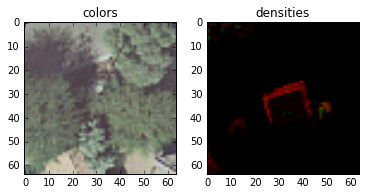

In [477]:
subplot(1,2,1)
imshow(patch[:3,:,:].transpose(1,2,0).clip(0,1))
title('colors')

subplot(1,2,2)
imshow((patch[3:6,:,:]/40).transpose(1,2,0).clip(0,1))
title('densities')

In [486]:
hs = hotspots[randint(len(hotspots))]
ctr = np.concatenate(hs.xy)

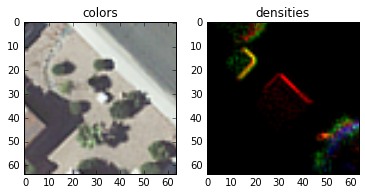

In [487]:
patch = gtp.get_patch_xyr(ctr[0], ctr[1], 45)
subplot(1,2,1)
imshow(patch[:3,:,:].transpose(1,2,0).clip(0,1))
title('colors')

subplot(1,2,2)
imshow((patch[3:6,:,:]/20).transpose(1,2,0).clip(0,1))
title('densities')